In [ ]:
!pip install opencv-contrib-python==4.4.0.44

In [ ]:
# Import required libraries
import cv2                               # OpenCV
import numpy as np                      
import pickle
import glob

import plotly.express as px
import plotly.graph_objects as go

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
from google.colab import drive
ROOT = "/content/drive"     # default location for drive
drive.mount(ROOT)

%cd "/content/drive/My Drive/cs283-final-project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs283-final-project


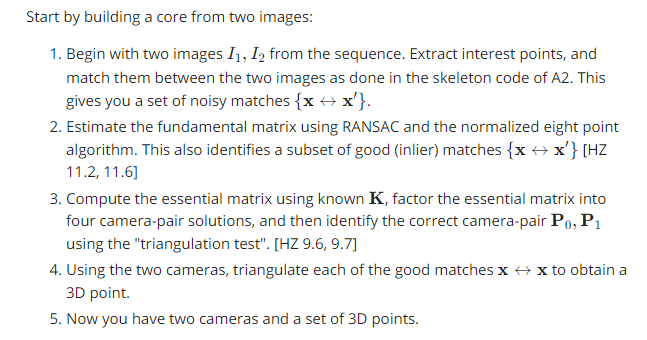

In [ ]:
# adjustable constants - Samsung Galaxy S10+ Camera Calibration at 100% focus length

camera_intrinsic = np.array([[2.78450324e+03, 0.00000000e+00, 1.51920882e+03], 
                    [0.00000000e+00, 2.79013509e+03, 1.92891193e+03], 
                    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
# extracting interest points from the images
img1 = cv2.imread('./winthrop_focus_100/winthrop-20.jpg')
img2 = cv2.imread('./winthrop_focus_100/winthrop-21.jpg')
im_gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
im_gray2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(im_gray1, None)
kp2, des2 = sift.detectAndCompute(im_gray2, None)

In [ ]:
# BFMatcher takes the descriptor of one feature in the first set and 
# is matched with all the other features in the second set using some threshold distance calculation,
# and the closest one is returned.
bf = cv2.BFMatcher(cv2.NORM_L2)

# Match descriptors (in both directions) between each pair of adjacent images
matches12 = bf.match(des1, des2)
matches21 = bf.match(des2, des1)

In [ ]:
# Prune keypoints to make sure matches are symmetric (i.e. only include matches which are 1-to-1)
matches12_sym = []
for i in range(len(matches12)):
    j = matches12[i].trainIdx
    # Only include j if it maps back to i
    if matches21[j].trainIdx == i:
        matches12_sym.append((i, j))

N = 400  # Number of matches to use in each image pair
# Find the N pairs with the lowest symmetric distance in each image pair
matches12_sym = sorted(matches12_sym, key=lambda x: matches12[x[0]].distance + matches21[x[1]].distance)[:N]
X12 = np.array([kp1[i].pt for i, _ in matches12_sym])
X21 = np.array([kp2[j].pt for _, j in matches12_sym])

In [ ]:
print(des1.shape)
print(des2.shape)
len(kp1)

(40614, 128)
(49426, 128)


40614

In [ ]:
len(matches12_sym)

400

(-0.5, 4015.5, 3007.5, -0.5)

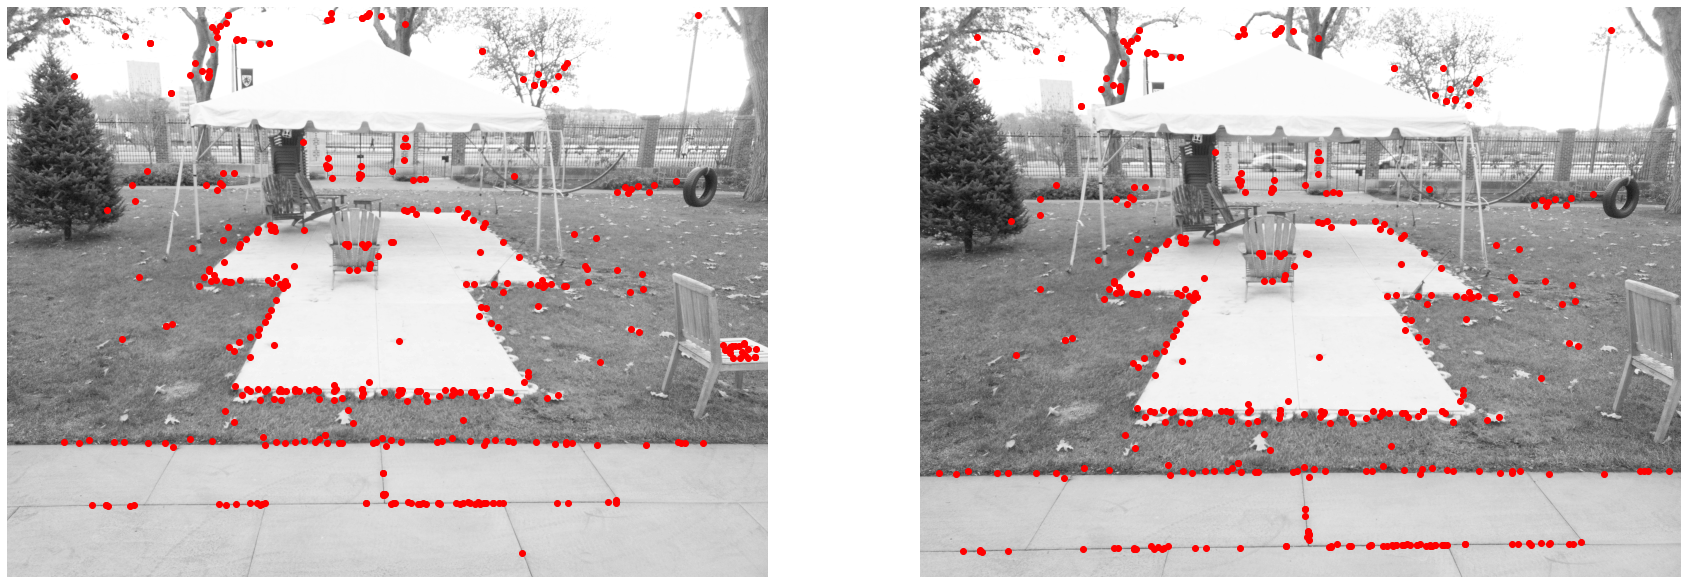

In [ ]:
plt.figure(figsize=[30, 30])
plt.subplot(1, 2, 1)
plt.imshow(im_gray1, cmap='gray')
plt.plot(X12[:, 0], X12[:, 1], 'or')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(im_gray2, cmap='gray')
plt.plot(X21[:, 0], X21[:, 1], 'or')
plt.axis('off')

In [ ]:
im_gray2.shape

(3008, 4016)

STEP 2. Deriving the Fundamental Matrix. 

Estimate the fundamental matrix using RANSAC and the normalized eight point algorithm. This also identifies a subset of good (inlier) matches {x <-> x'} 

Reference: HZ 11.2, 11.6

To read about the cv2 functions: https://stackoverflow.com/questions/25251676/opencv-findfundamentalmat-very-unstable-and-sensitive/39351844

In [ ]:
RANSAC_ITERATIONS = 100
RANSAC_THRESHOLD = 0.01
POINT_ALG = 8
N = 400

In [ ]:
"""
    Get normalizing matrix that averages points and scales to sqrt(2) dist
    Input: (3, 400)
"""
def get_normalizing_matrix(X):
    translation = np.reshape(np.average(X, axis=1), (3,1))
    X = X - translation
    scaling = np.average(np.sqrt(np.sum(np.square(X), axis=0)))
    translation *= np.sqrt(2) / scaling

    return np.array([[np.sqrt(2)/scaling, 0, -translation[0,0]], [0, np.sqrt(2)/scaling, -translation[1,0]], [0, 0, 1]])


"""Denormalize points according to translation, scaling matrices"""
def denormalize_points(translation, scaling, X):
    X *= scaling / np.sqrt(2)
    X += translation
    return X


"""
    Takes inhomogeneous vectors and outputs homogenenous vectors
    Input: 2 x n matrix, with n samples
    Output: 3 x n matrix, with n samples and a last row of all 1s
"""
def homogenize_points(X):
    assert(X.shape[0] == 2)
    Xn = np.concatenate((X, np.ones((1,X.shape[1]))), axis=0)
    assert(X.shape[1] == Xn.shape[1])
    return Xn


"""
    Finds number of inlier points based on distance metric. Here, we are guaranteed
    that F_candidate is 3x3 and assume that we want to find F s.t. x'T @ F @ x = 0
"""
def find_inliers(F_candidate, X1, X2, threshold_dist, N):
    counter = 0
    mask = []
    assert(X1.shape[1] == 3 and X2.shape[1] == 3)

    for i in range(N):
        inlier = (np.abs(X2[i].T @ F_candidate @ X1[i]) < threshold_dist)
        counter += inlier
        mask.append(inlier)
    return counter, mask

In [ ]:
"""Calculate the fundamental matrix, using RANSAC"""
def findFundamentalMat(X12, X21, N):
    # step 0: convert to homogeneous coordinates
    X12_h = homogenize_points(X12.T)
    X21_h = homogenize_points(X21.T)

    # step 1: normalization of x
    T1 = get_normalizing_matrix(X12_h)
    T2 = get_normalizing_matrix(X21_h)

    X12_hnorm = (T1 @ X12_h).T
    X21_hnorm = (T2 @ X21_h).T

    # step 2: finding fundamental matrix
    best_n_inliers = 0
    best_mask = []
    best_fundamental_matrix = []
    for iteration in range(RANSAC_ITERATIONS):
        # step 2a: finding a candidate fundamental matrix
        A = np.empty([0, 9], dtype=np.float32)
        indices = np.random.randint(0, high=len(X12), size=POINT_ALG)

        for i in indices:
            row_i = np.array([X21_hnorm[i,0] * X12_hnorm[i,0], \
                    X21_hnorm[i,0] * X12_hnorm[i,1], \
                  ], dtype=np.float)

            row_i = np.array([[X21_hnorm[i,0] * X12_hnorm[i,0], \
                  X21_hnorm[i,0] * X12_hnorm[i,1], \
                  X21_hnorm[i,0], \
                  X21_hnorm[i,1] * X12_hnorm[i,0], \
                  X21_hnorm[i,1] * X12_hnorm[i,1], \
                  X21_hnorm[i,1], \
                  X12_hnorm[i,0], \
                  X12_hnorm[i,1], \
                  1]], dtype=np.float) 
            A = np.concatenate((A, row_i), axis=0)

        assert(A.shape == (8, 9))

        _, _, p = np.linalg.svd(A)

        # change F_candidate to be rank 2 with SVD
        F_candidate = np.reshape(p[-1:], (3,3))
        u, d, v = np.linalg.svd(F_candidate)
        d[2] = 0
        F_candidate = u @ np.diag(d) @ v

        # Step 3: find inliers and count to see if it's greater than prior max
        n_inliers, mask = find_inliers(F_candidate, X12_hnorm, X21_hnorm, RANSAC_THRESHOLD, N)
        if n_inliers > best_n_inliers:
            best_n_inliers = n_inliers
            best_mask = mask
            best_fundamental_matrix = F_candidate

    # step 4: denormalization of fundamental matrix
    f_denormalized = T2.T @ best_fundamental_matrix @ T1
    return f_denormalized, best_mask

In [ ]:
print(X12.shape)

(400, 2)


In [ ]:
# 2. RANSAC to find the fundamental matrix:  findFundamentalMat()

F, mask = findFundamentalMat(X12, X21, N)
# We select only inlier points
mask = np.array(mask)
pts1 = X12[mask==1]
pts2 = X21[mask==1]

In [ ]:
print("The fundamental matrix is:")
print("{}".format(F))

The fundamental matrix is:
[[-3.97419333e-09  7.45368175e-07 -1.94750603e-03]
 [-6.96580100e-07 -1.58361997e-08  1.36045275e-03]
 [ 1.99258077e-03 -1.39710165e-03 -1.08317634e-01]]


(-0.5, 4015.5, 3007.5, -0.5)

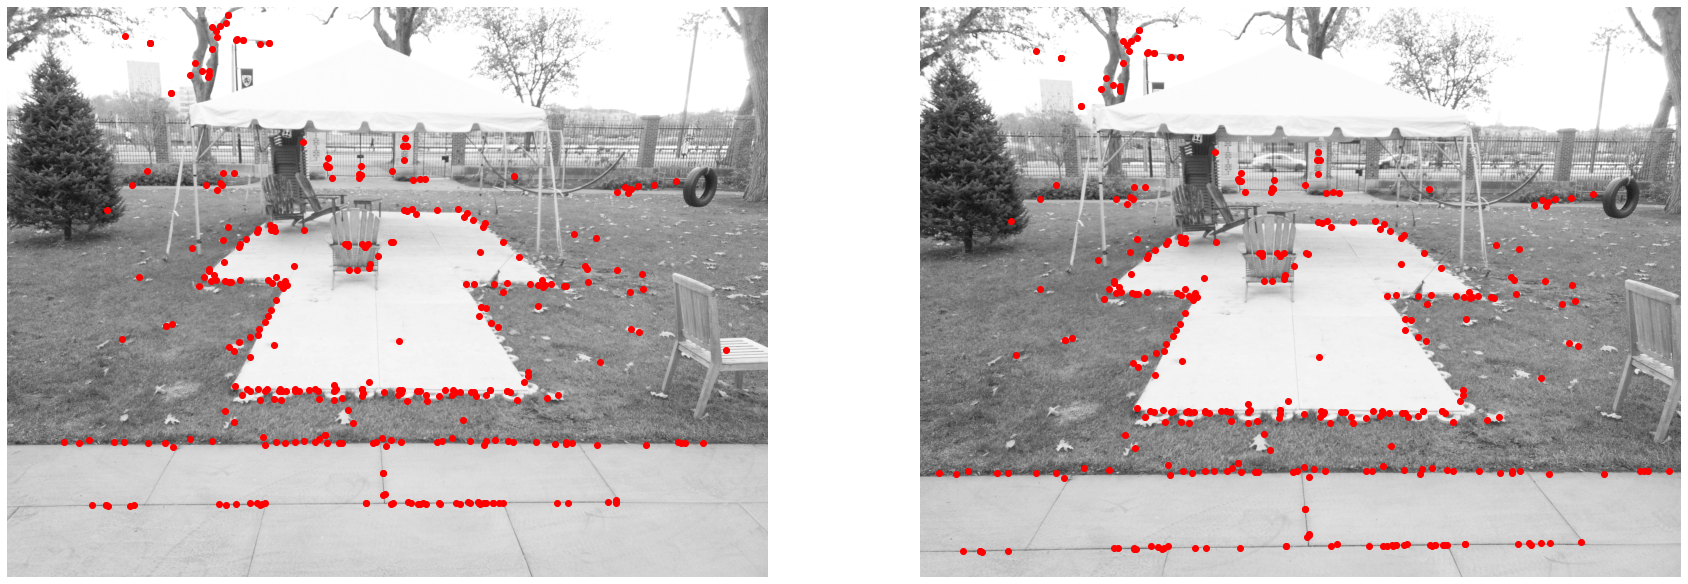

In [ ]:
plt.figure(figsize=[30, 30])
plt.subplot(1, 2, 1)
plt.imshow(im_gray1, cmap='gray')
plt.plot(pts1[:, 0], pts1[:, 1], 'or')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(im_gray2, cmap='gray')
plt.plot(pts2[:, 0], pts2[:, 1], 'or')
plt.axis('off')

STEP 3. Finding the Essential Matrix

In [ ]:
# 3. find the second position P_1 by using the essential matrix. 
# there will be an ambiguity of where to find the camera (front, back, etc.)
# findEssentialMat(), recoverPose(),

# note here that the camera matrices for K and K' in eq. 9.12 are using the same camera parameters
E = camera_intrinsic.T @ F @ camera_intrinsic
print("The essential matrix is")
print("{}".format(E))

The essential matrix is
[[-0.03081374  5.79086985 -1.43623031]
 [-5.41182846 -0.1232825   0.75795549]
 [ 1.79016124 -0.82386655 -0.03565682]]


In [ ]:
# Recover the pose. In recovering pose from the essential matrix,
# we assume the first camera matrix P has R = Identity and t = [0,0,0] (see Result 9.19 in HZ in Section 9.6.1)
n, R, t, _ = cv2.recoverPose(E, pts1, pts2, camera_intrinsic)
print("The rotation matrix is:")
print("{}".format(R))
print("The translation vector is:")
print("{}".format(t))

The rotation matrix is:
[[ 0.99991998  0.00848099  0.00938682]
 [-0.00916676  0.99709585  0.07560314]
 [-0.00871837 -0.07568314  0.9970938 ]]
The translation vector is:
[[-0.14037274]
 [-0.31022096]
 [-0.94024382]]


In [ ]:
# We actually only need one correspondence to identify the correct camera pair
n, R, t, mask_pose = cv2.recoverPose(E, pts1[0:1, :], pts2[0:1, :])
print("The rotation matrix of the second camera matrix is:")
print("{}".format(R))
print("The translation vector of the second camera matrix is:")
print("{}".format(t))

The rotation matrix of the second camera matrix is:
[[ 0.99991998  0.00848099  0.00938682]
 [-0.00916676  0.99709585  0.07560314]
 [-0.00871837 -0.07568314  0.9970938 ]]
The translation vector of the second camera matrix is:
[[0.14037274]
 [0.31022096]
 [0.94024382]]


In [ ]:
np.block([R,t])

array([[ 0.99991998,  0.00848099,  0.00938682,  0.14037274],
       [-0.00916676,  0.99709585,  0.07560314,  0.31022096],
       [-0.00871837, -0.07568314,  0.9970938 ,  0.94024382]])

In [ ]:
# Refer to example 9.2 (also found in M8 page 36)
# Suppose the camera matrices are those of calibrated stereo rig with the world origin at the first camera
P1 = camera_intrinsic @ np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]]) # K[I|0]
P2 = camera_intrinsic @ np.block([R,t]) # K[R|t] *** double check this formula is correct

print("The first camera matrix is:")
print("{}".format(P1))
print("The second camera matrix is:")
print("{}".format(P2))

The first camera matrix is:
[[2.78450324e+03 0.00000000e+00 1.51920882e+03 0.00000000e+00]
 [0.00000000e+00 2.79013509e+03 1.92891193e+03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
The second camera matrix is:
[[ 2.77103539e+03 -9.13631485e+01  1.54093134e+03  1.81929505e+03]
 [-4.23934854e+01  2.63604602e+03  2.13424910e+03  2.67920592e+03]
 [-8.71837322e-03 -7.56831350e-02  9.97093804e-01  9.40243824e-01]]


In [ ]:
"""
    Takes in camera matrices and transposes them
    Input: points must be dimension 2 x N
"""
def triangulatePoints_p(P1, P2, pts1, pts2):
    pts1 = homogenize_points(pts1)
    pts2 = homogenize_points(pts2)

    points = np.empty([0, 4], dtype=np.float32)
    for i in range(pts1.shape[1]):
        x, xp = pts1[0, i], pts2[0, i]
        y, yp = pts1[1, i], pts2[1, i]
        
        A = np.array([x * P1[2] - P1[0], y * P1[2] - P1[1],\
                      xp * P2[2] - P2[0], yp * P2[2] - P2[1]])
        
        _, _, p = np.linalg.svd(A)
        point = p[-1].reshape((1,4))
        if point[0,3] > 0:
            point *= -1
        points = np.concatenate((points, point), axis=0)

    return points

In [ ]:
# 4. use the two cameras to then reproject points in the two cameras into the 3D world. 
# triangulatePoints(), solvePnP(), solvePnPRansac(),

pts_3D = triangulatePoints_p(P1, P2, X12.transpose(), X21.transpose()) # note inputted points must be dimension 2 x N

In [ ]:
print(pts_3D.shape)

(400, 4)


In [ ]:
def to_inhomogeneous_3d(X):
  '''
  Takes in a Nx4 array of 3D homogeneous points
  Returns a Nx3 array of 3D inhomogeneous points
  '''
  return X[:, :3] / X[:, 3:]  # Note the difference between Xn[:, 2:] and Xn[:, 2]!

pts_3D_inhomog = to_inhomogeneous_3d(pts_3D)
print(pts_3D_inhomog.shape)
print("The first 3D point in homogeneous coordinates is: {}".format(pts_3D[0,:]))
print("The first 3D point is inhomogeneous coordinates is: {}".format(pts_3D_inhomog[0,:]))

(400, 3)
The first 3D point in homogeneous coordinates is: [-0.1659223  -0.484287    0.85596319 -0.07254589]
The first 3D point is inhomogeneous coordinates is: [  2.2871359    6.67559553 -11.79892111]


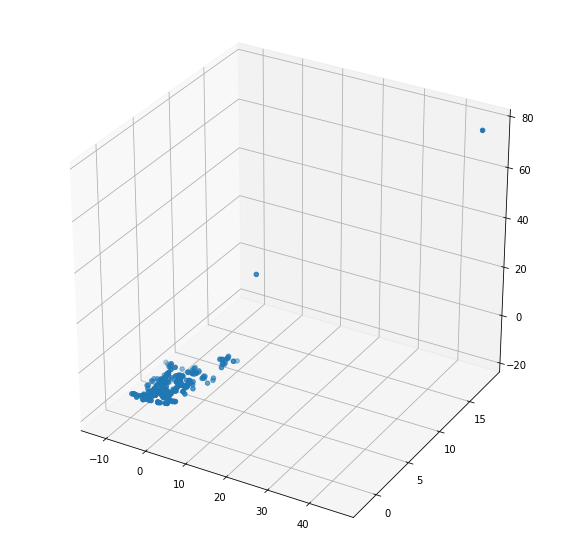

In [ ]:
# Plot points in 3D
# load plotting packages
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np

# begin plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# # find the five vertices of the pentahedron
# v = camera_polygon(calib_left, Pl_plus, Cl).transpose() #each row represents a 3d point
# w = camera_polygon(calib_right, Pr_plus, Cr).transpose() #each row represents a 3d point

ax.scatter3D(pts_3D_inhomog[mask.ravel()==1][:, 0], pts_3D_inhomog[mask.ravel()==1][:, 1], pts_3D_inhomog[mask.ravel()==1][:, 2])
# ax.scatter3D(v[:,0], v[:,1], v[:,2])
# ax.scatter3D(w[:,0], w[:,1], w[:,2])

# # generate list of sides' polygons of our pentahedron
# verts = [ [v[0],v[1],v[4]], [v[0],v[3],v[4]],
#  [v[2],v[1],v[4]], [v[2],v[3],v[4]], [v[0],v[1],v[2],v[3]]]

# verts2 = [ [w[0],w[1],w[4]], [w[0],w[3],w[4]],
#  [w[2],w[1],w[4]], [w[2],w[3],w[4]], [w[0],w[1],w[2],w[3]]]

# # # plot sides
# ax.add_collection3d(Poly3DCollection(verts, 
#  facecolors='blue', linewidths=1, edgecolors='b', alpha=.25))

# ax.add_collection3d(Poly3DCollection(verts2, 
#  facecolors='g', linewidths=1, edgecolors='g', alpha=.25))

plt.show()

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas
def plot_interactive_3d(X):
  import plotly.express as px
  df = pandas.DataFrame({"x": X[:,0], "y": X[:,1], "z": X[:,2]})
  fig = px.scatter_3d(df, x='x', y='y', z='z')
  fig.update_layout(scene_aspectmode="cube")
  fig.show()

plot_interactive_3d(pts_3D_inhomog[mask.ravel()==1])

(-0.5, 4015.5, 3007.5, -0.5)

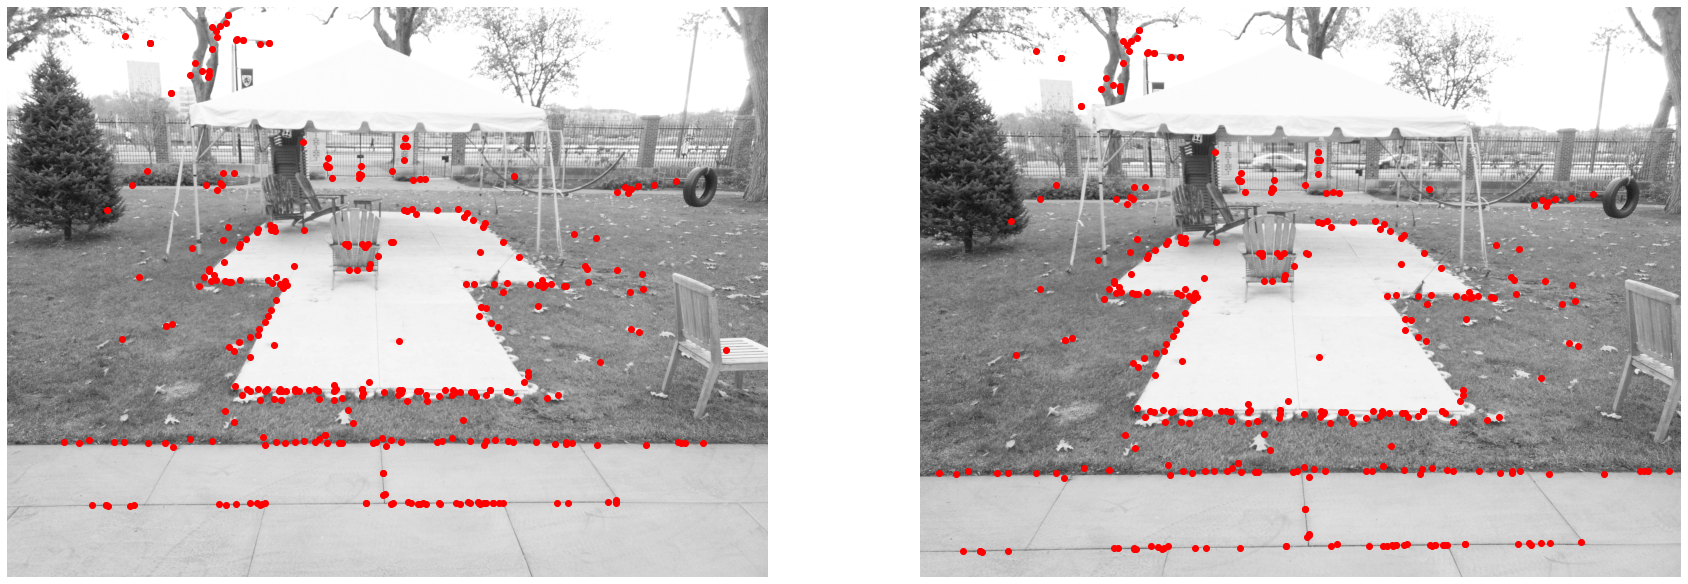

In [ ]:
plt.figure(figsize=[30, 30])
plt.subplot(1, 2, 1)
plt.imshow(im_gray1, cmap='gray')
plt.plot(pts1[:, 0], pts1[:, 1], 'or')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(im_gray2, cmap='gray')
plt.plot(pts2[:, 0], pts2[:, 1], 'or')
plt.axis('off')

SLAM Pipeline, Adding New Images

In [ ]:
import copy
from scipy import linalg

In [ ]:
N_IMAGES = 24
N = 400
REPROJECT_N = 200

# BFMatcher takes the descriptor of one feature in the first set and 
# is matched with all the other features in the second set using some threshold distance calculation,
# and the closest one is returned.
bf = cv2.BFMatcher(cv2.NORM_L2)
camera_centers = []

In [ ]:
"""
    Finds the matching points with previous sift descriptor, for which we already have 3D world representations
    Input:
    - matches12_sym: contains points in the prior matching for which we have 3D world points
    - matches12_sym_p: contains new matches, for which we want to match with R and t matrix
"""
def find_matching_points(matches12_sym, matches12_sym_p, pts_3D_inhomog, img_mask_p):
    pnp_matches = []
    pnp_3D = []

    # matching the second column of first vec and first col of second vec, corresponding pts
    for i in range(len(matches12_sym)):
        if img_mask_p[i] == 1:
            for j in range(len(matches12_sym_p)):
                if matches12_sym[i][1] == matches12_sym_p[j][0]:
                    pnp_matches.append(matches12_sym_p[j])
                    pnp_3D.append(pts_3D_inhomog[i])
    return np.array(pnp_matches), np.array(pnp_3D)


"""Prune keypoints to make sure matches are symmetric (i.e. only include matches which are 1-to-1)"""
def prune_symmetric(matches12_p, matches21_p):
    matches12_sym_p = []
    for i in range(len(matches12_p)):
        j = matches12_p[i].trainIdx
        # Only include j if it maps back to i
        if matches21_p[j].trainIdx == i:
            matches12_sym_p.append((i, j))

    return matches12_sym_p

In [ ]:
# driver code for multi-image layering on top of two-image SLAM
for i in range(22, 24):
    print(f"iteration: {i}")

    # extracting interest points from the images
    img_p = cv2.imread(f'./winthrop_focus_100/winthrop-{i}.jpg')
    im_gray_p= cv2.cvtColor(img_p,cv2.COLOR_BGR2GRAY)

    sift = cv2.xfeatures2d.SIFT_create()
    kp_p, des_p = sift.detectAndCompute(im_gray_p, None)

    # Match descriptors (in both directions) between each pair of adjacent images
    matches12_p = bf.match(des2, des_p)
    matches21_p = bf.match(des_p, des2)

    # Prune keypoints to make sure matches are symmetric (i.e. only include matches which are 1-to-1)
    matches12_sym_p = prune_symmetric(matches12_p, matches21_p)

    # find the matching points, in later iterations its just reprojection of best 400 points in sift
    pnp_matches, pnp_3D = find_matching_points(matches12_sym, matches12_sym_p, to_inhomogeneous_3d(pts_3D), mask)

    # Find exact points where there were point correspondances
    X12_p = np.array([kp2[i].pt for i, _ in pnp_matches])
    X21_p = np.array([kp_p[j].pt for _, j in pnp_matches])

    _, mask_p = findFundamentalMat(X12_p, X21_p, len(X21_p))

    mask_p = np.array(mask_p)
    # We select only inlier points from RANSAC fundamental matrix
    pts2_p = X21_p[mask_p.ravel()==1]

    _, R_vec_p, t_p = cv2.solvePnP(pnp_3D[mask_p.ravel()==1], pts2_p, camera_intrinsic, distCoeffs = False)
    R_p, _ = cv2.Rodrigues(R_vec_p)

    # new extrinsic camera matrix
    P_p = camera_intrinsic @ np.block([R_p, t_p])

    print(len(matches12_sym_p))
    camera_centers.append(linalg.null_space(P_p))
    matches12_sym_reproject = sorted(matches12_sym_p, key=lambda x: matches12_p[x[0]].distance + matches21_p[x[1]].distance)[:REPROJECT_N]

    X12_reproject = np.array([kp2[i].pt for i, _ in matches12_sym_reproject])
    X21_reproject = np.array([kp_p[j].pt for _, j in matches12_sym_reproject])

    pts_3D_reproject = triangulatePoints_p(P2, P_p, X12_reproject.transpose(), X21_reproject.transpose()) # note inputted points must be dimension 2 x N

    pts_3D = np.concatenate((pts_3D, pts_3D_reproject), axis = 0)

    # mask used so that top REPROJECT_N points will be reprojected out into the world
    mask = np.ones(REPROJECT_N)

    # setting variables up for processing next image
    matches12_sym = copy.deepcopy(matches12_sym_reproject) # we need to add points for which they have 3D correspondances
    kp2 = kp_p
    des2 = copy.deepcopy(des_p)
    P2 = copy.deepcopy(P_p)

iteration: 22
18772
iteration: 23
19838


In [ ]:
camera_centers.append(linalg.null_space(P_p))
matches12_sym_reproject = sorted(matches12_sym_p, key=lambda x: matches12_p[x[0]].distance + matches21_p[x[1]].distance)[:REPROJECT_N]

X12_reproject = np.array([kp2[i].pt for i, _ in matches12_sym_reproject])
X21_reproject = np.array([kp_p[j].pt for _, j in matches12_sym_reproject])

pts_3D_reproject = triangulatePoints_p(P2, P_p, X12_reproject.transpose(), X21_reproject.transpose()) # note inputted points must be dimension 2 x N

pts_3D = np.concatenate((pts_3D, pts_3D_reproject), axis = 0)

# mask used so that top REPROJECT_N points will be reprojected out into the world
mask = np.ones(REPROJECT_N)

# setting variables up for processing next image
matches12_sym = copy.deepcopy(matches12_sym_reproject) # we need to add points for which they have 3D correspondances
kp2 = kp_p
des2 = copy.deepcopy(des_p)
P2 = copy.deepcopy(P_p)

In [ ]:
print(pts_3D.shape)

(1000, 4)


In [39]:
camera_centers = np.reshape(np.array(camera_centers), (3,4))
camera_centers_inh = to_inhomogeneous_3d(camera_centers)

In [40]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas
def plot_interactive_3d(X):
  import plotly.express as px
  df = pandas.DataFrame({"x": X[:,0], "y": X[:,1], "z": X[:,2]})
  fig = px.scatter_3d(df, x='x', y='y', z='z')

  fig.update_layout(scene_aspectmode="cube")
  fig.show()

pts_3D_pruned = pts_3D[np.linalg.norm(pts_3D, axis=1) < 1]
pts_3D_inh = to_inhomogeneous_3d(pts_3D_pruned)
pts_3D_pruned = pts_3D_inh[np.linalg.norm(pts_3D_inh, axis=1) < 100]
plot_interactive_3d(pts_3D_pruned)
plot_interactive_3d(camera_centers_inh)

Scrap

In [ ]:
assert(1==0)

In [ ]:
# Prune keypoints to make sure matches are symmetric (i.e. only include matches which are 1-to-1)
matches12_sym_p = []
for i in range(len(matches12_p)):
    j = matches12_p[i].trainIdx
    # Only include j if it maps back to i
    if matches21_p[j].trainIdx == i:
        matches12_sym_p.append((i, j))

In [ ]:
img_mask_p = mask
pnp_matches = []
pnp_3D = []

# matching the second column of first vec and first col of second vec, corresponding pts
for i in range(len(matches12_sym)):
    if img_mask_p[i] == 1:
        for j in range(len(matches12_sym_p)):
            if matches12_sym[i][1] == matches12_sym_p[j][0]:
                pnp_matches.append(matches12_sym_p[j])
                pnp_3D.append(pts_3D_inhomog[i])

pnp_matches = np.array(pnp_matches)
pnp_3D = np.array(pnp_3D)

In [ ]:
# Find the N pairs with the lowest symmetric distance in each image pair
X12_p = np.array([kp2[i].pt for i, _ in pnp_matches])
print(X12_p.shape)
X21_p = np.array([kp_p[j].pt for _, j in pnp_matches])
print(X21_p.shape)

In [ ]:
# DO NOT PROCEED UNTIL LOOKING UP OTHER FUNCTIONS THAT MAY SERVE SIMILAR PURPOSE
# 2. RANSAC to find the fundamental matrix:  findFundamentalMat()

F_p, mask_p = cv2.findFundamentalMat(X12_p, X21_p, cv2.RANSAC)
# We select only inlier points
pts1_p = X12_p[mask_p.ravel()==1]
pts2_p = X21_p[mask_p.ravel()==1]

In [ ]:
print(pts1_p.shape)
print(pts2_p.shape) 

In [ ]:
pnp_3D[mask_p.ravel()==1].shape

In [ ]:
a, R_vec_p, t_p = cv2.solvePnP(pnp_3D[mask_p.ravel()==1], pts2_p, camera_intrinsic, distCoeffs = False)
R_p, _ = cv2.Rodrigues(R_vec_p)

In [ ]:
R_p

Reproject and add new points to the 3D reconstruction of the world

In [ ]:
P_p = camera_intrinsic @ np.block([R_p, t_p])
P_p

In [ ]:
# we need to find a new set of points to add to the set
pts_3D.shape

In [ ]:
N = 400  # Number of matches to use in each image pair
# Find the N pairs with the lowest symmetric distance in each image pair
matches12_sym_reproject = sorted(matches12_sym, key=lambda x: matches12[x[0]].distance + matches21[x[1]].distance)[:N]
X12_reproject = np.array([kp1[i].pt for i, _ in matches12_sym_reproject])
X21_reproject = np.array([kp2[j].pt for _, j in matches12_sym_reproject])

assert(X12_reproject.shape == (400, 2))
assert(X21_reproject.shape == (400, 2))

In [ ]:
pts_3D_reproject = triangulatePoints_p(P2, P_p, X12_reproject.transpose(), X21_reproject.transpose()) # note inputted points must be dimension 2 x N

In [ ]:
pts_3D = np.concatenate((pts_3D, pts_3D_reproject), axis = 0)

In [ ]:
pts_3D

In [ ]:
# invariants that should be satisfied from previous section
assert(mask.shape == (N,))
assert(pts_3D.shape == (N, 4))
assert(np.array(matches12_sym).shape == (N, 2))

Scrap

In [ ]:
# extracting interest points from the images
img_p = cv2.imread('./winthrop_focus_100/winthrop-22.jpg')
im_gray_p= cv2.cvtColor(img_p,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp_p, des_p = sift.detectAndCompute(im_gray_p, None)

In [ ]:
# BFMatcher takes the descriptor of one feature in the first set and 
# is matched with all the other features in the second set using some threshold distance calculation,
# and the closest one is returned.
bf = cv2.BFMatcher(cv2.NORM_L2)

# Match descriptors (in both directions) between each pair of adjacent images
matches12_p = bf.match(des2, des_p)
matches21_p = bf.match(des_p, des2)

In [ ]:
pnp_matches, pnp_3D = find_matching_points(matches12_sym, matches12_sym_p, to_inhomogeneous_3d(pts_3D))

# Find exact points where there were point correspondances
X12_p = np.array([kp2[i].pt for i, _ in pnp_matches])
X21_p = np.array([kp_p[j].pt for _, j in pnp_matches])


print(X12_p.shape)
print(X21_p.shape)

F_p, mask_p = cv2.findFundamentalMat(X12_p, X21_p, cv2.RANSAC, len(X21_p))

print(pnp_3D.shape)

# We select only inlier points from RANSAC fundamental matrix
pts1_p = X12_p[mask_p.ravel()==1]
pts2_p = X21_p[mask_p.ravel()==1]

_, R_vec_p, t_p = cv2.solvePnP(pnp_3D[mask_p.ravel()==1], pts2_p, camera_intrinsic, distCoeffs = False)
R_p, _ = cv2.Rodrigues(R_vec_p)

# new extrinsic camera matrix
P_p = camera_intrinsic @ np.block([R_p, t_p])

print(len(matches12_sym_p))

matches12_sym_reproject = sorted(matches12_sym_p, key=lambda x: matches12_p[x[0]].distance + matches21_p[x[1]].distance)[:REPROJECT_N]

X12_reproject = np.array([kp2[i].pt for i, _ in matches12_sym_reproject])
X21_reproject = np.array([kp_p[j].pt for _, j in matches12_sym_reproject])

pts_3D_reproject = triangulatePoints_p(P2, P_p, X12_reproject.transpose(), X21_reproject.transpose()) # note inputted points must be dimension 2 x N

pts_3D = np.concatenate((pts_3D, pts_3D_reproject), axis = 0)

# mask used so that top REPROJECT_N points will be reprojected out into the world
mask = np.concatenate((mask, np.ones(REPROJECT_N)))

# setting variables up for processing next image
matches12_sym = matches12_sym_p
kp2 = kp_p